# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/zero_shot_atsc'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

Mounted at /content/drive
/content/drive/My Drive/zero_shot_atsc
     |████████████████████████████████| 1.9MB 9.2MB/s 
     |████████████████████████████████| 163kB 37.0MB/s 
     |████████████████████████████████| 245kB 33.2MB/s 
     |████████████████████████████████| 10.4MB 25.3MB/s 
     |████████████████████████████████| 22.3MB 95kB/s 
     |████████████████████████████████| 3.2MB 49.0MB/s 
     |████████████████████████████████| 890kB 48.4MB/s 
     |████████████████████████████████| 245kB 54.9MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f535cf209d231f6fb86dc6f3953406b721119f6aa57f6cb35925ff73e6aeff9c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing i

## Experiment parameters

In [2]:
import os

# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'prompt_lr_atsc_single_prompt_the_aspect_bert_amazon_electronics'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
mlm_model_path = os.path.join(
    'progress', 'lm_further_pretraining_bert_amazon_electronics_bseoh_2021-03-06--18_59_53',
    'results', 'checkpoint-1180388')

# Proportion to be reserved for validation
validation_dataset_proportion = 0.2

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is [MASK].",
]

# Training settings for logistic regression head
lr_training_epochs = 10
lr_training_batch_size = 32
lr_training_learning_rate = 1e-3
lr_validation_batch_size = 32
lr_testing_batch_size = 32

## Package imports

In [3]:
import sys
import os
import random
import shutil
import copy

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
NumPy version: 1.19.5
PyTorch version: 1.8.0+cu101
Transformers version: 4.3.3


## PyTorch GPU settings

In [4]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = False
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = True
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 10.1
cuDNN Version: 7603
CUDA Device Name: Tesla T4
CUDA Capabilities: (7, 5)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [5]:
# Load semeval for both domains
in_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': 'dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': 'dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='dataset_cache')


out_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': 'dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': 'dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='dataset_cache')

Using custom data configuration default


Using custom data configuration default


Dataset sem_eval2014_task4_dataset downloaded and prepared to dataset_cache/sem_eval2014_task4_dataset/default-f3f89d732e1bec7c/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969. Subsequent calls will reuse this data.


Reusing dataset sem_eval2014_task4_dataset (dataset_cache/sem_eval2014_task4_dataset/default-f51da598aeeb968e/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [6]:
out_domain_train = out_domain_semeval_dataset['train']
out_domain_test = out_domain_semeval_dataset['test']

in_domain_test = in_domain_semeval_dataset['test'] # Never use in-domain training data

## Train-validation split for out-domain SemEval data

In [7]:
# Training set size after validation split
new_out_domain_train_dataset_size = int(len(out_domain_train) * (1 - validation_dataset_proportion))
new_out_domain_valid_dataset_size = len(out_domain_train) - new_out_domain_train_dataset_size

print("Training dataset (out-domain) after split:", new_out_domain_train_dataset_size)
print("Validation dataset (out-domain) after split:", new_out_domain_valid_dataset_size)

Training dataset (out-domain) after split: 2881
Validation dataset (out-domain) after split: 721


In [8]:
out_domain_train = out_domain_train.shuffle(seed=random_seed)

new_out_domain_train_dataset = out_domain_train.select(
    indices=np.arange(new_out_domain_train_dataset_size))
new_out_domain_valid_dataset = out_domain_train.select(
    indices=np.arange(
        new_out_domain_train_dataset_size,
        new_out_domain_train_dataset_size + new_out_domain_valid_dataset_size))

Loading cached shuffled indices for dataset at dataset_cache/sem_eval2014_task4_dataset/default-f51da598aeeb968e/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-b1be74464447108a.arrow


In [9]:
print(new_out_domain_train_dataset[0])

{'aspect': 'Unda (Egg) rolls', 'sentiment': 0, 'text': 'I really recommend the very simple Unda (Egg) rolls.'}


# Zero-shot ATSC with Prompts + Logistic Regression Head

## Load the pretrained LM

In [10]:
# Load pretrained language model
mlm = transformers.AutoModelForMaskedLM.from_pretrained(mlm_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='bert_base_cache')

## Define a new model with logistic regression head

In [11]:
classifier_model = utils.MultiPromptSentimentClassificationHead(
    mlm=mlm,
    num_class=3, num_prompts=len(sentiment_prompts), mask_token_id=tokenizer.mask_token_id)

# Freeze the MLM main layer
for param in classifier_model.mlm.parameters():
    param.requires_grad = False

classifier_model = classifier_model.to(device=torch_device)

## Training settings

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    new_out_domain_train_dataset, batch_size=lr_training_batch_size,
    pin_memory=use_pin_memory)

validation_dataloader = torch.utils.data.DataLoader(
    new_out_domain_valid_dataset, batch_size=lr_validation_batch_size,
    pin_memory=use_pin_memory)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = transformers.AdamW(classifier_model.parameters(), lr=lr_training_learning_rate)

# The directory to save the best version of the head
trained_model_directory = os.path.join('.', 'trained_models', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [13]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

In [14]:
best_validation_loss = float('inf')
best_epoch = -1

for epoch in tqdm.notebook.tqdm(range(int(lr_training_epochs))):

    print("Training epoch %d" % epoch)
    print()

    classifier_model.train()

    for batch in tqdm.notebook.tqdm(train_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch["text"]

            for aspect in batch["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded = batch_encoded.to(torch_device)

        labels = batch["sentiment"]
        labels = labels.to(torch_device)

        optimizer.zero_grad()

        outputs = classifier_model(batch_encoded)
        
        loss = loss_function(outputs, labels)

        loss.backward()

        optimizer.step()

    # Validate the model using val dataset
    classifier_model.eval()

    print("Validation epoch %d" % epoch)
    print()

    predictions_val = torch.Tensor([])
    labels_val = torch.Tensor([])

    for batch_val in tqdm.notebook.tqdm(validation_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch_val["text"]

            for aspect in batch_val["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded.to(torch_device)

        labels = batch_val["sentiment"]

        outputs = classifier_model(batch_encoded)

        outputs = outputs.to('cpu')

        predictions_val = torch.cat([predictions_val, outputs])
        labels_val = torch.cat([labels_val, labels])
    
    # Compute metrics
    validation_loss = torch.nn.functional.cross_entropy(predictions_val, labels_val.long())
    validation_metrics = compute_metrics(predictions_val, labels_val)

    print(
        "Epoch {}, Training Loss: {}, Validation Loss: {}, Validation Metrics: {}".format(epoch, loss.item(), validation_loss.item(), validation_metrics))
    print()

    # Save the current epoch's model if the validation loss is lower than the best known so far
    if validation_loss.item() < best_validation_loss:
        best_validation_loss = validation_loss.item()
        best_epoch = epoch
        torch.save(classifier_model.linear, os.path.join(trained_model_directory, 'epoch_{}.pt'.format(epoch)))

Training epoch 0




Validation epoch 0




Epoch 0, Training Loss: 0.39533281326293945, Validation Loss: 0.6390435695648193, Validation Metrics: {'accuracy': 0.7337031900138696, 'f1': 0.5495561196205082, 'precision': 0.6376388110706759, 'recall': 0.5585951413085559}

Training epoch 1




Validation epoch 1




Epoch 1, Training Loss: 0.41409239172935486, Validation Loss: 0.6116108894348145, Validation Metrics: {'accuracy': 0.7447988904299584, 'f1': 0.5895295254720716, 'precision': 0.6590677139846833, 'recall': 0.5896322106078203}

Training epoch 2




Validation epoch 2




Epoch 2, Training Loss: 0.34213095903396606, Validation Loss: 0.6007015109062195, Validation Metrics: {'accuracy': 0.7517337031900139, 'f1': 0.6134282587979977, 'precision': 0.6786401680323286, 'recall': 0.6071143050716221}

Training epoch 3




Validation epoch 3




Epoch 3, Training Loss: 0.19242936372756958, Validation Loss: 0.5896077156066895, Validation Metrics: {'accuracy': 0.7545076282940361, 'f1': 0.6232351890723973, 'precision': 0.6741498965995865, 'recall': 0.6174566879597367}

Training epoch 4




Validation epoch 4




Epoch 4, Training Loss: 0.38382893800735474, Validation Loss: 0.5829876661300659, Validation Metrics: {'accuracy': 0.7545076282940361, 'f1': 0.6237457580223491, 'precision': 0.6735130277436431, 'recall': 0.6125195993031359}

Training epoch 5




Validation epoch 5




Epoch 5, Training Loss: 0.33785170316696167, Validation Loss: 0.5788805484771729, Validation Metrics: {'accuracy': 0.7600554785020804, 'f1': 0.6283929538429324, 'precision': 0.6811350777934937, 'recall': 0.6194425087108014}

Training epoch 6




Validation epoch 6




Epoch 6, Training Loss: 0.2566927969455719, Validation Loss: 0.5732384324073792, Validation Metrics: {'accuracy': 0.7656033287101248, 'f1': 0.6384492761279913, 'precision': 0.6917648442951495, 'recall': 0.6302973770809137}

Training epoch 7




Validation epoch 7




Epoch 7, Training Loss: 0.2157214730978012, Validation Loss: 0.5702764391899109, Validation Metrics: {'accuracy': 0.7628294036061026, 'f1': 0.6440918393204541, 'precision': 0.6897029983442242, 'recall': 0.6351950251645374}

Training epoch 8




Validation epoch 8




Epoch 8, Training Loss: 0.3148086369037628, Validation Loss: 0.5677294135093689, Validation Metrics: {'accuracy': 0.7628294036061026, 'f1': 0.6367700926524456, 'precision': 0.686721489473045, 'recall': 0.626340737514518}

Training epoch 9




Validation epoch 9




Epoch 9, Training Loss: 0.3111346960067749, Validation Loss: 0.5657653212547302, Validation Metrics: {'accuracy': 0.7614424410540915, 'f1': 0.6326982437804892, 'precision': 0.6783453675635096, 'recall': 0.6226403406891212}




## Evaluation with in-domain test set



In [15]:
test_dataloader = torch.utils.data.DataLoader(
    in_domain_test, batch_size=lr_testing_batch_size,
    pin_memory=use_pin_memory)

In [16]:
# Load the best found head weights
classifier_model.linear = torch.load(
    os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)),
    map_location=torch_device)

classifier_model.eval()

predictions_test = torch.Tensor([])
labels_test = torch.Tensor([])

for batch_val in tqdm.notebook.tqdm(test_dataloader):

    reviews_repeated = []
    prompts_populated = []

    for prompt in sentiment_prompts:
        reviews_repeated = reviews_repeated + batch_val["text"]

        for aspect in batch_val["aspect"]:
            prompts_populated.append(prompt.format(aspect=aspect))

    batch_encoded = tokenizer(
        reviews_repeated, prompts_populated,
        padding='max_length', truncation='only_first', max_length=256,
        return_tensors='pt')
    
    batch_encoded.to(torch_device)

    labels = batch_val["sentiment"]

    outputs = classifier_model(batch_encoded)

    outputs = outputs.to('cpu')

    predictions_test = torch.cat([predictions_test, outputs])
    labels_test = torch.cat([labels_test, labels])

# Compute metrics
test_metrics = compute_metrics(predictions_test, labels_test)

print(test_metrics)


{'accuracy': 0.7304075235109718, 'f1': 0.6463799030803844, 'precision': 0.7173117129212029, 'recall': 0.6831086291190199}


## Results visualization

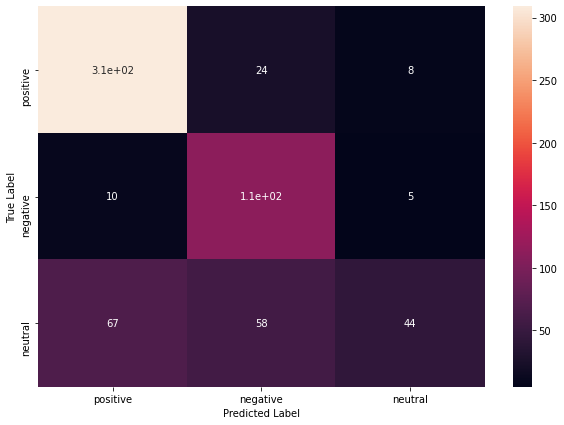

In [20]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()